# Setup

In [1]:
#https://www.kaggle.com/piotrstanczyk/gfootball-template-bot  G-FOOTBALL TEMPLATE BOT
# Install:
# Kaggle environments.
!git clone https://github.com/Kaggle/kaggle-environments.git
!cd kaggle-environments && pip install .

# GFootball environment.
!apt-get update -y
!apt-get install -y libsdl2-gfx-dev libsdl2-ttf-dev

# Make sure that the Branch in git clone and in wget call matches !!
!git clone -b v2.8 https://github.com/google-research/football.git
!mkdir -p football/third_party/gfootball_engine/lib

!wget https://storage.googleapis.com/gfootball/prebuilt_gameplayfootball_v2.8.so -O football/third_party/gfootball_engine/lib/prebuilt_gameplayfootball.so
!cd football && GFOOTBALL_USE_PREBUILT_SO=1 pip3 install .

Cloning into 'kaggle-environments'...
remote: Enumerating objects: 4235, done.
remote: Counting objects: 100% (1015/1015), done.
remote: Compressing objects: 100% (322/322), done.
remote: Total 4235 (delta 812), reused 811 (delta 691), pack-reused 3220
Receiving objects: 100% (4235/4235), 11.38 MiB | 8.40 MiB/s, done.
Resolving deltas: 100% (2569/2569), done.
Processing /content/kaggle-environments
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 63 kB 640 kB/s 
  Created wheel for kaggle-environments: filename=kaggle_environments-1.9.7-py3-none-any.whl size=1813048 sha256=f58dd7959a3c606b87250cac5bacb77c2

# All the imports

In [13]:
from gfootball.env.football_env import FootballEnv
from kaggle_environments import make
from gfootball.env.config import Config
from gfootball.env.football_env import FootballEnv

#import dqn libraries
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import numpy as np
import pandas as pd
import itertools
import random
from collections import deque
import matplotlib.pyplot as plt

#import env 
import gym
import gfootball 

#env_name = "GFootballBase-v0"
#print(env_name)

# Initialize variables

In [3]:
BUFFERSIZE = 100000  #how many experiences will store |ReplayBufferSize=100,000
REWBUFFERSIZE = 100   #how many episode rewards will store|RewardBufferSize =100
MINREPLAYSIZE= 3000 # Episode is 3000 steps
GAMMA = 0.04
EPSILON =0.03
TARGET_UPDATE_FREQ = 25

EPSILON_START=1.0
EPSILON_END =0.2
EPSILON_DECAY=10000

BATCH_SIZE = 3


# Deep Q Network Model

In [4]:
class DQN(nn.Module):
  def __init__(self,env):
    super(DQN,self).__init__()
    input_dims = int(np.prod(env.observation_space.shape)) #neurons input layer = number of observations
    self.net =nn.Sequential(nn.Linear(input_dims,200), 
                            nn.Tanh(),
                            nn.Linear(200,env.action_space.n)) # neurons outpul layer = number of observations 
                            
  def forward(self,x):
    return self.net(x) #use the dqnetwork

  def act(self,obs): #returns the best acrtion/highest value action of the net 
    obs_t =torch.as_tensor(obs,dtype=torch.float32)
    q_values=self(obs_t.unsqueeze(0)) # make tensor a batch dimension

    max_q_index = torch.argmax(q_values,dim=1)[0]   # taking action with highest q value
    action = max_q_index.detach().item() # making tensor to integer which represents action 
    
    return action 



# Agent 

In [5]:
class Agent() : 
  def __init__(self,gamma,epsilon):
    self.gamma =gamma
    self.epsilon =epsilon
    
    self.ReplayBuffer = deque(maxlen=BUFFERSIZE) #Store experiences 
    self.RewBuffer = deque(maxlen=REWBUFFERSIZE) #Store rewards
    
    self.online_net = DQN(env)   
    self.target_net = DQN(env)  

    self.target_net.load_state_dict(self.online_net.state_dict())


  def transition(self,obs,new_obs,action,reward ,done): # should be tuple ? 
    self.obs =obs
    self.action=action
    self.reward =reward 
    self.done=done
    #self.info =info
    self.new_obs =new_obs
    TransitionTuple= (obs,new_obs,action,reward,done)
    #print("class",TransitionTuple)
    return TransitionTuple

  def learn(self,optimizer):
    self.optimizer=torch.optim.Adam(self.online_net.parameters(),lr =0.02) 
    


# All Prints

In [43]:
class All_prints():
  
  def __init___(self,step):
    self.step=step
    #self.RewBuffer = RewBuffer
    self.reward=reward

  def printstats(self,step,RewBuffer,eps_reward):  #Kaleitai otan ginei done , diladi otan teleiosei ena paixnidi
    self.step=step
    self.RewBuffer=RewBuffer
    self.eps_reward=eps_reward
    print("-->Episode:",self.step%3000 + 1 ,"\t","Episode Reward:",self.eps_reward,"<--")
    print("Step",step)
    print("lista apo rewards mexri tora" ,self.RewBuffer)
    print("Avg reward", np.mean(self.RewBuffer))
    print("---------------------------------------------------")

  def print_who_scored(self, reward):
    self.reward=reward
    if(self.reward==-1):
      print("opponent team scored")
    elif(self.reward==1):
      print("our team scored !!!")
 
  def rew_graph(self,RewBuffer,step,num_of_eps):
      self.RewBuffer=RewBuffer
      self.step=step
      self.num_of_eps=num_of_eps

      episode=self.step%3000
      eps_list=list(range(1,self.num_of_eps+1))#pairnei to proto , den pairnei to teleytaio
      #print(agent.RewBuffer,eps_list)
      plt.plot(eps_list,self.RewBuffer)
      plt.xlabel('Episode')
      plt.ylabel('Rewards')
      plt.grid(True)
      plt.show()

# Create Environment -- Main 


opponent team scored
opponent team scored
opponent team scored
opponent team scored
opponent team scored
-->Episode: 1 	 Episode Reward: -5.0 <--
Step 3000
lista apo rewards mexri tora deque([-5.0], maxlen=100)
Avg reward -5.0
---------------------------------------------------
opponent team scored
opponent team scored
-->Episode: 2 	 Episode Reward: -2.0 <--
Step 6001
lista apo rewards mexri tora deque([-5.0, -2.0], maxlen=100)
Avg reward -3.5
---------------------------------------------------
opponent team scored
opponent team scored
opponent team scored
-->Episode: 3 	 Episode Reward: -3.0 <--
Step 9002
lista apo rewards mexri tora deque([-5.0, -2.0, -3.0], maxlen=100)
Avg reward -3.3333333333333335
---------------------------------------------------
opponent team scored
-->Episode: 4 	 Episode Reward: -1.0 <--
Step 12003
lista apo rewards mexri tora deque([-5.0, -2.0, -3.0, -1.0], maxlen=100)
Avg reward -2.75
---------------------------------------------------
opponent team scored

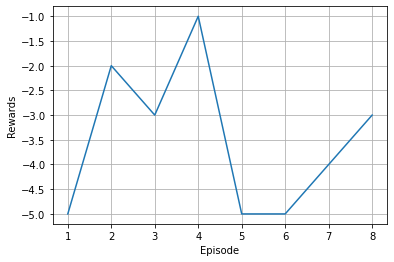

In [44]:
#if __name__ =='main': 
#TO DO : MAKE A CLASS FOR ALL PRINTS 
#TO DO : MAKE REPLAY BUFFER A CLASS
#MAKE A CLASS FOR LEARNING

env = gym.make("GFootball-11_vs_11_kaggle-simple115v2-v0") #List with the 115 states 
eps_reward =0.0

obs = env.reset()

#CREATE OBJECTS 
agent=Agent(GAMMA,EPSILON) #Agent class
all_prints=All_prints() # print class

#Initialize ReplayBuffer # TO DO : MAKE IT A CLASS
for i in range(MINREPLAYSIZE): 
  action =env.action_space.sample() #random action 

  new_obs ,reward,done ,info = env.step(action) 

  transition = agent.transition(obs,new_obs,action,reward ,done) #obs ,action ,reward , done ,info , new_obs  PROSEKSE TO MALLON LATHOS
  agent.ReplayBuffer.append(transition)  #Fill Replay Buffer with transitions
  obs=new_obs

 
  if(done):  # if someone score  a goal reset the env 
    obs=env.reset()


# MAIN TRAIN LOOP
obs =env.reset()
c= 0
num_of_eps= 8     #GIVE NUMBER OF EPISODES

for step in range((3000 * num_of_eps) + num_of_eps ):# play 3000 steps = 1 match = 1 episode
  
  
  #epsilon greedy
  epsilon = np.interp(step,[0,EPSILON_DECAY],[EPSILON_START,EPSILON_END]) #Epsilon start->end with epsilon decays steps from 100% random actions->2% rnd actions
  rnd_sample = random.random()
  
  if rnd_sample <= epsilon: #random action |explore|
    action = env.action_space.sample()
  else:  
    action = agent.online_net.act(obs) #best action |exploit|     YPARXEI THEMA EDO PERA , POU GEMIZEI TO ONLINE NET ??
# return action 
  
  
  
  new_obs,reward,done,info = env.step(action)

  all_prints.print_who_scored(reward)

  transition = agent.transition(obs,new_obs,action,reward ,done) #fill Replaybuffer with transitions 

  agent.ReplayBuffer.append(transition) # To Replay Buffer gemizei kanonika
  obs=new_obs

  eps_reward = eps_reward+reward
  #print("eps_reward:",eps_reward,"rew:",reward,info,done)

  if (done) :
    
    obs=env.reset()
   
    agent.RewBuffer.append(eps_reward)

    #Print Resume when an episode ends 
    all_prints.printstats(step,agent.RewBuffer,eps_reward)
    #print(step)
    if(step == (3000 * num_of_eps)+num_of_eps -1):
       
      all_prints.rew_graph(agent.RewBuffer,step,num_of_eps)
    
    eps_reward =0.0 


# Start Gradient Step 
  transitions =random.sample(agent.ReplayBuffer , BATCH_SIZE) #sample batch_size number of random transitions from Replaybuffer ,
                                                              # Replay buffer have been filled earlier
 #Store convert -> return pytorch tensors 
  #Store observations as arrays
  obses = np.asarray([t[0] for t in transitions])
  new_obses = np.asarray([t[1]for t in transitions])
  actions = np.asarray([t[2] for t in transitions])
  rewards = np.asarray([t[3] for t in transitions])
  dones = np.asarray([t[4] for t in transitions])
  
  #Convert observation arrays to pytorch tensors
  obses_t=torch.as_tensor(obses,dtype=torch.float32)
  actions_t = torch.as_tensor(actions,dtype=torch.int64).unsqueeze(-1) #making batch dimension to one dimension
  rewards_t = torch.as_tensor(rewards,dtype= torch.float32).unsqueeze(-1)
  dones_t = torch.as_tensor(dones,dtype= torch.float32).unsqueeze(-1)
  new_obses_t = torch.as_tensor(new_obses,dtype= torch.float32)


  #Compute Targets
  
  target_q_values = agent.target_net(new_obses_t)# q values for each observation 
  max_target_q_values = target_q_values.max(dim=1,keepdim=True)[0] #take the maximum value in dim =1 , discard all the rest dimensions
                                                                  #max returns tuple , first element is highest values and second is the index to them 

  targets = rewards_t +GAMMA + (1-dones_t) * max_target_q_values #deepmind_atari_paper dqn learn with replay
                                                                #if its a terminal state: dones_t =1 -> targets= rewards_t

  #Compute Loss
  q_values = agent.online_net(obses_t)
  action_q_values =torch.gather(input=q_values,dim=1,index=actions_t)
  loss=nn.functional.smooth_l1_loss(action_q_values,targets)

  #Gradient Descent -> NA MPEI SE SYNARTHSH LEARN TOU AGENT 
  optimizer=torch.optim.Adam(agent.online_net.parameters(),lr =0.02)
  #print(optimizer)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Update the target network, copying all weights and biases in DQN
  if step% TARGET_UPDATE_FREQ == 0:   #Update target network based on online network
    agent.target_net.load_state_dict(agent.online_net.state_dict())

  
  




In [ ]:
# obs = env.reset()
# a = env.step(action)
# print(obs ,'\n New obs:',a)

In [ ]:
# env = make("football", debug=True, configuration={"save_video": False, "scenario_name": "11_vs_11_kaggle", "running_in_notebook": True})
# env.render

In [ ]:
# ena =env.reset() 
# #dyo=simple_env.reset()

# #print(ena.shape)
# print(ena[0])#olo to environment
# #pprint.pprint(ena[0])


In [ ]:
# %%writefile submission.py
# from kaggle_environments.envs.football.helpers import *

# ## @human_readable_agent wrapper modifies raw observations 
# # provided by the environment:
# # https://github.com/google-research/football/blob/master/gfootball/doc/observation.md#raw-observations
# # into a form easier to work with by humans.
# # Following modifications are applied:
# # - Action, PlayerRole and GameMode enums are introduced.
# # - 'sticky_actions' are turned into a set of active actions (Action enum)
# #    see usage example below.
# # - 'game_mode' is turned into GameMode enum.
# # - 'designated' field is removed, as it always equals to 'active'
# #    when a single player is controlled on the team.
# # - 'left_team_roles'/'right_team_roles' are turned into PlayerRole enums.
# # - Action enum is to be returned by the agent function.
# @human_readable_agent
# def agent(obs):
#     # Make sure player is running.
#     if Action.Sprint not in obs['sticky_actions']:
#         return Action.Sprint
#     # We always control left team (observations and actions
#     # are mirrored appropriately by the environment).
#     controlled_player_pos = obs['left_team'][obs['active']]
#     # Does the player we control have the ball?
#     if obs['ball_owned_player'] == obs['active'] and obs['ball_owned_team'] == 0:  #EXEI PAIKTIS TIN MPALA KAI EINAI STIN ARISTERI OMADA
#         # Shot if we are 'close' to the goal (based on 'x' coordinate).
#         if controlled_player_pos[0] > 0.5:
#             return Action.Shot
#         # Run towards the goal otherwise.
#         return Action.Right
#     else:
#         # Run towards the ball.
#         if obs['ball'][0] > controlled_player_pos[0] + 0.05:
#             return Action.Right
#         if obs['ball'][0] < controlled_player_pos[0] - 0.05:
#             return Action.Left
#         if obs['ball'][1] > controlled_player_pos[1] + 0.05:
#             return Action.Bottom
#         if obs['ball'][1] < controlled_player_pos[1] - 0.05:
#             return Action.Top
#         # Try to take over the ball if close to the ball.
#         return Action.Slide

In [ ]:
# # Set up the Environment.
# from kaggle_environments import make
# env = make("football", configuration={"save_video": True, "scenario_name": "11_vs_11_kaggle", "running_in_notebook": True})
# output = env.run(["/kaggle/working/submission.py", "do_nothing"])[-1]
# print('Left player: reward = %s, status = %s, info = %s' % (output[0]['reward'], output[0]['status'], output[0]['info']))
# print('Right player: reward = %s, status = %s, info = %s' % (output[1]['reward'], output[1]['status'], output[1]['info']))
# env.render(mode="human", width=800, height=600)